In [1]:
import nest
import nest.raster_plot
import numpy as np
from sklearn.decomposition import PCA

from utils.inputs import generate_piecewise_constant_signal
from utils.extractors import filter_spikes, filter_spikes_parallel
from utils.capacity import compute_capacity

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: bioseq@4a9a61a5d
 Built: Feb 14 2024 16:44:44

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In this example, we will evaluate the ability of the network to represent a continuous input signal. We will drive the network with the patterned stimulus (similar to the previous example), and use a linear decoder to reconstruct this signal based on the population responses.

# Global settings

In [2]:
seed = 1
np.random.seed(seed)

In [3]:
dt = 0.1  # simulation resolution
num_threads = 8

# Initialize NEST
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})


Oct 15 09:46:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


---
# Balanced Random Network

For this example, we will use a standard Brunel balanced random network (see NEST tutorials). However, you are encouraged to explore different neuron and synapse models and/or more complex connectivity schemes.

In [4]:
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

In [5]:
# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

In [6]:
# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

### Create and connect populations

In [7]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create excitatory connections
# synapse specification
syn_exc = {'delay': d, 'weight': w}
# connection specification
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
# connect stuff
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# create inhibitory connections
# synapse specification
syn_inh = {'delay': d, 'weight': - g * w}
# connection specification
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
# connect stuff
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

### Create and connect external inputs
We are going to drive the circuit with a patterned stimulus signal.

In [8]:
# external input (stimulus)
step_duration = 20.    # [ms]
scale = 10000.         # input scaling factor [Hz]
num_steps = 100        # number of unique input values

sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, num_steps=num_steps, 
                                                                           step_duration=step_duration, 
                                                                           resolution=dt, scale=scale)

Text(0.5, 1.0, '$u(t)$')

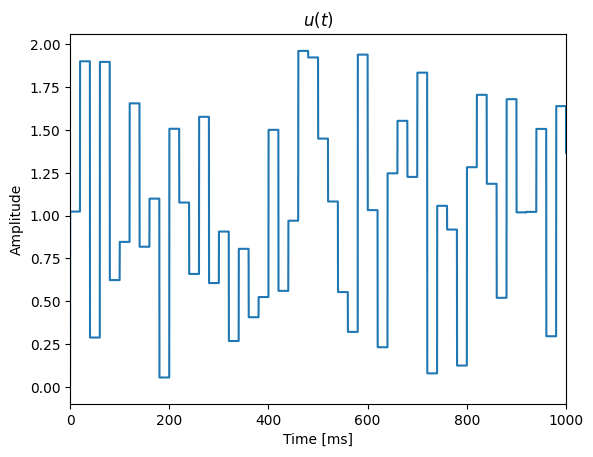

In [9]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(times, sig)
ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [10]:
# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
stim_pgen.set({'rate_times': inp_times, 'rate_values': inp_amplitudes})

In [11]:
# connect poisson generator using the excitatory connection weight
nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

### Create and connect recording devices
Note: we will restrict the analysis to the activity of the excitatory neurons. If you run into memory or time constraints, you can also downsample and record from a smaller subset of neurons.

In [12]:
spikes = nest.Create('spike_recorder')
nest.Connect(neurons_e, spikes)

## Simulate

In [13]:
sim_time = num_steps*step_duration
nest.Simulate(sim_time)  


Oct 15 09:46:19 NodeManager::prepare_nodes [Info]: 
    Preparing 1266 nodes for simulation.

Oct 15 09:46:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1266
    Simulation time (ms): 2000
    Number of OpenMP threads: 8
    Not using MPI

Oct 15 09:46:19 SimulationManager::run [Info]: 
    Simulation finished.


### Post-process data

In order to evaluate the capacity, we need a continuous state variable. This can be done either by recording the $V_{m}$ and using it directly, or low-pass filtering the recorded spikes (estimate the instantaneous rates). In this example, we use the later case. Note that this implementation is very time-consuming so for later examples, we will use the $V_{m}$ instead and sub-sample it to acquire one single state vector per input step. These population activity state vectors are gathered and stored in a matrix, $X$.

In [14]:
filter_tau = 20. # [ms]

activity = spikes.events
# states = filter_spikes(activity['times'], activity['senders'], NE, t_start=0., t_stop=num_steps*step_duration, dt=dt, tau=filter_tau)

# if you can use parallelization, it can be very useful here:
states = filter_spikes_parallel(activity['times'], activity['senders'], NE, t_start=0., t_stop=num_steps*step_duration, dt=dt, tau=filter_tau, n_processes=num_threads)

Filtering SpikeTrains: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.10it/s]


## Decoding
If the input-driven dynamics contains enough information, we should be able to reconstruct some target signal. For this purpose, we will use standard linear regression (see helper functions). If the state of the circuit is stored in a matrix $X$ and the target signal to reconstruct is $y$, we can estimate the optimal linear projection as:
\begin{equation}
D = \left( X^{T}X\right)^{-1} X^{T}Y
\end{equation}

In the simplest case that we explore in this example, we want to reconstruct the original input signal, i.e. $y(t)=u(t)$. 

We can measure the circuit's capacity to reconstruct $y(t)$ as:
\begin{equation}
\mathrm{C}[\mathrm{X}, \mathrm{y}]=\frac{\left<y(t)\hat{y}(t)\right>_{T}^{2}}{\sigma^2(y)\sigma^2(\hat{y})}
\end{equation}

where $\hat{y}(t)$ is the reconstructed signal. This measure is normalized, so if the circuit optimally represents the input, $\mathrm{C}[\mathrm{X}, \mathrm{y}]=1$.

In [15]:
# exclude initial values at 0.
sig = sig[1:]
times = times[1:]

In [16]:
estimate, capacity, error = compute_capacity(states, sig)
print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))


Elapsed time for capacity computation: 11.913909196853638
Capacity=0.7818617881248033, MSE=0.07378763873975992


Let's visualize the results:

Text(0.5, 0, 'Time [ms]')

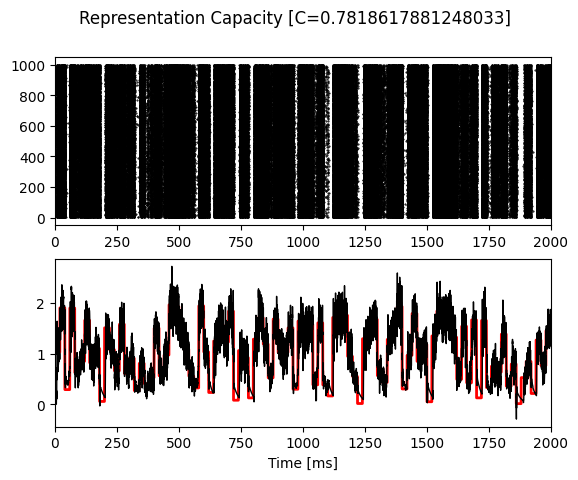

In [17]:
fig = plt.figure()
fig.suptitle('Representation Capacity [C={0}]'.format(str(capacity)))
ax11 = fig.add_subplot(211)
ax12 = fig.add_subplot(212, sharex=ax11)
ax11.plot(activity['times'], activity['senders'], '.k', markersize=1)
ax11.set_xlim([0., num_steps*step_duration])
ax12.plot(times, sig, 'r', linewidth=2)
ax12.plot(times, estimate, 'k', linewidth=1)
ax12.set_xlabel(r'Time [ms]')

It is frequently useful to graphically analyze population activity in a low-dimensional space, as obtained, for example, by principal component analysis

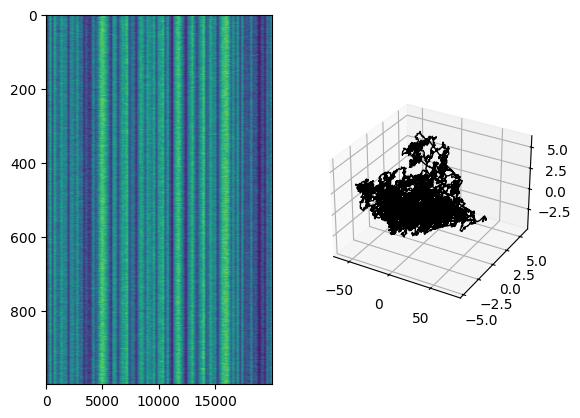

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(states, aspect='auto')
ax2 = fig.add_subplot(122, projection='3d')
pca_fit = PCA(n_components=np.shape(states)[0])
X = pca_fit.fit_transform(states.T)
ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)